<a href="https://colab.research.google.com/github/olympiabz/QM2/blob/main/Regression_Discontinuity_ESSA_Per_Pupil_Expenditure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

# Reload the dataset to start fresh
population_df = pd.read_csv('/content/Public v3 (4).csv')

# Ensure the 'Population' column is treated as a string to apply .str.replace()
population_df['Population'] = population_df['Population'].astype(str).str.replace(',', '', regex=False)

# Convert the cleaned 'Population' column to numeric
population_df['Population'] = pd.to_numeric(population_df['Population'], errors='coerce')

# Reload the original dataset to ensure 'Year' and 'State' columns are present
df = pd.read_csv('/content/Public v3 (3).csv') # Reloading the original dataset

# Group shootings data by Year and State
grouped_shootings = df.groupby(['Year', 'State']).size().reset_index(name='Shooting_Count')

# Merge the shootings data with the population data
merged_df = pd.merge(grouped_shootings, population_df, on='State', how='left')

# Calculate shootings per 100,000 people
merged_df['Shootings_per_100k'] = (merged_df['Shooting_Count'] / merged_df['Population']) * 100000

# Pivot the data to have states as rows and years as columns
pivot_table = merged_df.pivot(index='State', columns='Year', values='Shootings_per_100k')

# Replace NaN values with 0
pivot_table = pivot_table.fillna(0)

# Save the final dataset to a CSV file
pivot_table.to_csv('shootings_per_100k_per_year.csv')

# Preview the cleaned dataset
print("\nCleaned Dataset (Preview):")
print(pivot_table.head())


Cleaned Dataset (Preview):
Year     1966.0  1967.0    1968.0  1969.0    1970.0    1971.0    1972.0  \
State                                                                     
AK     0.000000     0.0  0.000000     0.0  0.000000  0.000000  0.000000   
AL     0.000000     0.0  0.000000     0.0  0.000000  0.000000  0.000000   
AR     0.000000     0.0  0.000000     0.0  0.032597  0.000000  0.000000   
AZ     0.000000     0.0  0.000000     0.0  0.000000  0.013457  0.000000   
CA     0.005133     0.0  0.002566     0.0  0.002566  0.002566  0.005133   

Year     1973.0    1974.0    1975.0  ...    2015.0    2016.0    2017.0  \
State                                ...                                 
AK     0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
AL     0.019575  0.000000  0.000000  ...  0.019575  0.039151  0.058726   
AR     0.000000  0.032597  0.000000  ...  0.065195  0.032597  0.032597   
AZ     0.000000  0.000000  0.000000  ...  0.013457  0.013457  0.000000   
CA

                            WLS Regression Results                            
Dep. Variable:              Shootings   R-squared:                       0.387
Model:                            WLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     178.0
Date:                Fri, 17 Jan 2025   Prob (F-statistic):           1.82e-89
Time:                        12:46:07   Log-Likelihood:                 1608.2
No. Observations:                 850   AIC:                            -3208.
Df Residuals:                     846   BIC:                            -3189.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0134      0.004      3.554

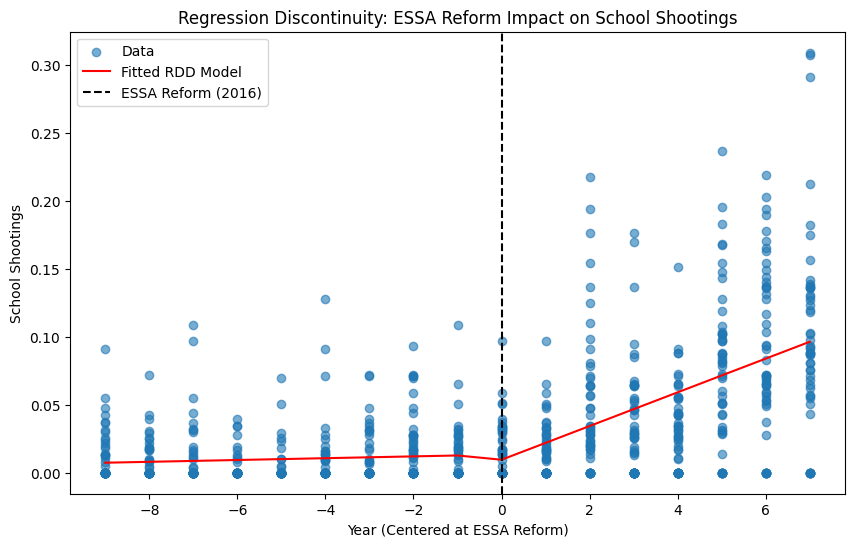

In [8]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Load the data (replace with your actual file paths)
shootings_file = 'shootings_per_100k_per_year.csv'  # File containing state-wise school shootings
spending_file = 'df_ppcs_2007_2023_updated.csv'     # File containing per-pupil spending (2007-2023)

# Load the data into pandas DataFrames
shootings_df = pd.read_csv(shootings_file)
spending_df = pd.read_csv(spending_file)

# Reshape shootings_df: Wide to long format
shootings_long = shootings_df.melt(id_vars=['State'], var_name='Year', value_name='Shootings')
shootings_long['Year'] = shootings_long['Year'].astype(float).astype(int)  # Convert Year to integer

# Reshape spending_df: Wide to long format
spending_long = spending_df.melt(id_vars=['State'], var_name='Year', value_name='Spending')
spending_long['Year'] = spending_long['Year'].str.extract('(\d+)').astype(int)  # Extract year from column names

# Merge the reshaped dataframes on 'State' and 'Year'
data = pd.merge(shootings_long, spending_long, on=['State', 'Year'])

# Ensure the dataset contains years (2007-2023) and valid data
data = data[(data['Year'] >= 2007) & (data['Year'] <= 2023)]

# Define the threshold year (ESSA reform: 2016)
threshold_year = 2016

# Create a variable for spending centered around the threshold year
data['Year_centered'] = data['Year'] - threshold_year

# Create a threshold dummy variable (1 if year is after or in 2016, 0 otherwise)
data['After_ESSA'] = (data['Year'] >= threshold_year).astype(int)

# Interaction term for the regression model
data['Interaction'] = data['Year_centered'] * data['After_ESSA']

# Run the regression model
model = smf.wls("Shootings ~ Year_centered + After_ESSA + Interaction", data).fit()

# Print the regression results
print(model.summary())

# Visualize the results
plt.figure(figsize=(10, 6))

# Scatterplot of data
plt.scatter(data['Year_centered'], data['Shootings'], alpha=0.6, label='Data')

# Plot the regression lines
plt.plot(
    data['Year_centered'],
    model.predict(data),
    color='red',
    label='Fitted RDD Model',
)

# Mark the threshold year
plt.axvline(0, color='black', linestyle='--', label='ESSA Reform (2016)')
plt.title('Regression Discontinuity: ESSA Reform Impact on School Shootings')
plt.xlabel('Year (Centered at ESSA Reform)')
plt.ylabel('School Shootings')
plt.legend()
plt.show()
